In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

random_seed = 42

import os
mlflow_tracking_uri = os.path.join(os.path.dirname(os.getcwd()), 'mlruns')
print(f"MLflow tracking URI: {mlflow_tracking_uri}")

# Change to \\ if on Windows
if os.name == 'nt':
    mlflow.set_tracking_uri(f"file:\\{mlflow_tracking_uri}")
else:
    mlflow.set_tracking_uri(f"file://{mlflow_tracking_uri}")

mlflow.end_run()
mlflow.set_experiment("regression_nn")

MLflow tracking URI: /Users/hayden/UPEI/CS4120_ML/CS4120-MLProject/project/mlruns


<Experiment: artifact_location='file:///Users/hayden/UPEI/CS4120_ML/CS4120-MLProject/project/mlruns/704883388407280999', creation_time=1763919677705, experiment_id='704883388407280999', last_update_time=1763919677705, lifecycle_stage='active', name='regression_nn', tags={}>

In [41]:
df = pd.read_csv('../data/train.csv')

# Combine bathroom features
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df = df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)

# Combine porch features into one
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df = df.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)

# Drop low-variance features
df = df.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'], axis=1)

# Drop Year/Month sold (temporal features may cause overfitting)
df = df.drop(['MoSold', 'YrSold'], axis=1)

# Combine quality features
df['OverallScore'] = df['OverallQual'] * df['OverallCond']
# Redundant features
df = df.drop(['GarageType', 'GarageFinish', 'Fence', 'Alley'], axis=1)
df = df.drop(['LowQualFinSF', 'PoolArea', 'MiscVal'], axis=1)
df = df.drop(['GarageQual', 'GarageCond'], axis=1)
df = df.drop(['PoolQC', 'MiscFeature'], axis=1)

X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1460, 56)
Target shape: (1460,)


In [42]:
# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)

In [43]:
X_train['MSSubClass'] = X_train['MSSubClass'].astype(str)
X_test['MSSubClass'] = X_test['MSSubClass'].astype(str)

numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"Preprocessed training data shape: {X_train_preprocessed.shape}")

Preprocessed training data shape: (1168, 240)


Best parameters from Grid Search: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64, 32), 'solver': 'adam'}


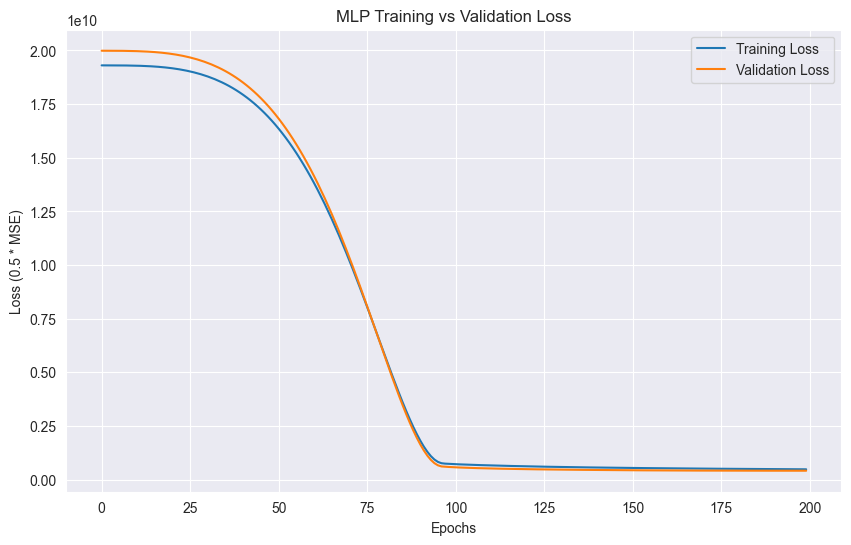

2025/11/23 13:54:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 13:54:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


----------------------------------------
Training Set Performance:
RMSE: 33488.39
MAE: 19535.87
R²: 0.8120
----------------------------------------
Test Set Performance:
RMSE: 35397.83
MAE: 20838.65
R²: 0.8366
----------------------------------------


In [44]:
mlp_for_grid = MLPRegressor(
    max_iter=500,
    random_state=random_seed,
    early_stopping=True,
    n_iter_no_change=20,
    verbose=False,
)

param_grid = {
    'hidden_layer_sizes': [
        (100,),
        (100, 50),
        (64, 32),
        (128, 64, 32),
    ],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01]
}

grid_search = GridSearchCV(
    mlp_for_grid,
    param_grid,
    cv=4,
    scoring='neg_mean_squared_error',
)

grid_search.fit(X_train_preprocessed, y_train)
best_params = grid_search.best_params_
print(f"Best parameters from Grid Search: {best_params}")

with mlflow.start_run(run_name="regression_nn_final_model"):
    mlflow.log_params(best_params)
    mlflow.log_param("final_max_iter", 100)
    mlflow.log_param("random_seed", random_seed)

    X_t, X_v, y_t, y_v = train_test_split(
        X_train_preprocessed, y_train, test_size=0.2, random_state=random_seed
    )

    model = MLPRegressor(
        **best_params,
        max_iter=1,
        warm_start=True,
        random_state=random_seed
    )

    train_loss_history = []
    val_loss_history = []

    epochs = 200

    for epoch in range(epochs):
        model.fit(X_t, y_t)
        train_loss_history.append(model.loss_)

        val_pred = model.predict(X_v)
        val_loss = mean_squared_error(y_v, val_pred) / 2
        val_loss_history.append(val_loss)

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('MLP Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (0.5 * MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    final_params = grid_search.best_params_.copy()
    final_params.pop("max_iter", None)
    final_model = MLPRegressor(
        **final_params,
        max_iter=100,
        early_stopping=False,
        random_state=random_seed,
        verbose=False
    )
    final_model.fit(X_train_preprocessed, y_train)
    y_train_pred = final_model.predict(X_train_preprocessed)
    y_pred = final_model.predict(X_test_preprocessed)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("train_r2", train_r2)

    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)

    mlflow.sklearn.log_model(final_model, artifact_path="final_model")

    mlflow.set_tag("model_type", "MLPRegressor_regression_nn")

    print("-"*40)
    print("Training Set Performance:")
    print(f"RMSE: {train_rmse:.2f}")
    print(f"MAE: {train_mae:.2f}")
    print(f"R²: {train_r2:.4f}")
    print("-"*40)
    print("Test Set Performance:")
    print(f"RMSE: {test_rmse:.2f}")
    print(f"MAE: {test_mae:.2f}")
    print(f"R²: {test_r2:.4f}")
    print("-"*40)

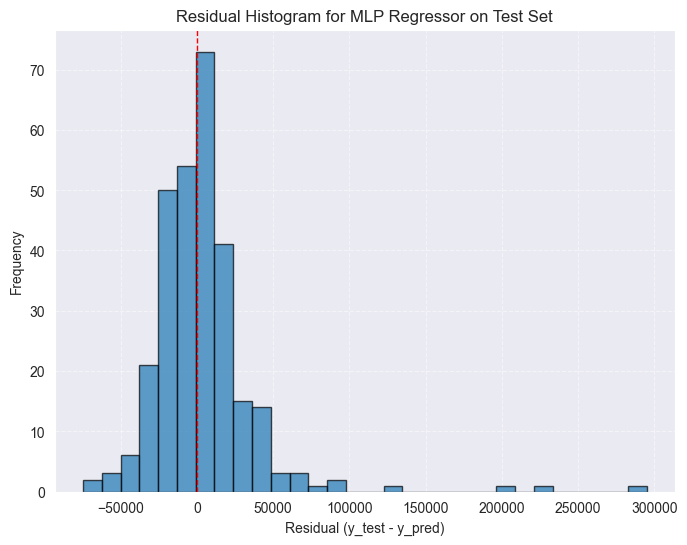

In [46]:
# Residual histogram: distribution of residuals on the test set
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Residual (y_test - y_pred)')
plt.ylabel('Frequency')
plt.title('Residual Histogram for MLP Regressor on Test Set')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()